## Exploratory Data Analysis

In this section, we explored the characteristics of the dataset.

In [1]:
import cv2
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Compute n_frames
def compute_n_frames(root_dir):
    """
    Compute the number of frames based on the .pkl files in the specified directory.
    Args:
        root_dir (str): Path to the directory containing .pkl files.
    Returns:
        int: Number of frames.
    """
    n_frames = 0
    for f in os.listdir(root_dir):
        if f.endswith('.pkl'):
            with open(os.path.join(root_dir, f), 'rb') as file:
                data = pickle.load(file)
                n_frames += data['image_feats'].shape[0] 

    return n_frames

In [4]:
#PRELIMINARIES: CREATE DATA MATRICES

#a. Create a matrix of images (condense into single channel)
# Each .pkl file contains: image_feats, kinematics_feats, g_labels, e_labels, and frames.

root_dir = "../data/LOSO/5Hz/1Out/"
n_trials = len([f for f in os.listdir(root_dir) if f.endswith('.pkl')])
n_frames = compute_n_frames(root_dir)

image_data = torch.empty((n_frames, 2048))
kinematics_data = torch.empty((n_frames, 26))
g_labels_data = torch.empty((n_frames, 1))
e_labels_data = torch.empty((n_frames, 5))
task_data = torch.empty((n_frames, 1))
trial_data = torch.empty((n_frames, 1))
subject_data = pd.DataFrame(columns=['subject'], index=range(n_frames))

frame_index = 0

for pkl_file in os.listdir(root_dir):
    
    if pkl_file.endswith('.pkl'):

        print(f"Processing file: {pkl_file}")
        
        pkl_path = os.path.join(root_dir, pkl_file)
        with open(pkl_path, 'rb') as file:
            data = pickle.load(file)

        n_frames_in_trial = data['image_feats'].shape[0]

        #i. Image features
        image_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data['image_feats']).reshape(n_frames_in_trial, 2048)

        #ii. Kinematics features
        kinematics_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data['kinematics_feats'])

        #iii. Gesture labels
        g_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data['g_labels']).reshape(n_frames_in_trial, 1)

        #iv. Error labels
        e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data['e_labels']).reshape(n_frames_in_trial, 5)

        #v. Task labels
        if pkl_file.startswith("Needle"):
            task_data[frame_index : frame_index + n_frames_in_trial] = 0 #Needle_Passing
        
        elif pkl_file.startswith("Suturing"):
            task_data[frame_index : frame_index + n_frames_in_trial] = 1

        #vi. Trial labels
        #Remove .pkl
        pkl_file = pkl_file[:-4]
        trial_data[frame_index : frame_index + n_frames_in_trial] = int(pkl_file[-1])

        #vii. Subject labels (literally the pkl_file)
        subject = pkl_file
        subject_data.iloc[frame_index : frame_index + n_frames_in_trial] = subject

        frame_index += n_frames_in_trial

Processing file: Suturing_G005.pkl
Processing file: Needle_Passing_E001.pkl
Processing file: Suturing_G004.pkl
Processing file: Suturing_I001.pkl
Processing file: Suturing_E001.pkl
Processing file: Needle_Passing_I002.pkl
Processing file: Suturing_E003.pkl
Processing file: Suturing_I003.pkl
Processing file: Needle_Passing_E003.pkl
Processing file: Suturing_I002.pkl
Processing file: Suturing_E002.pkl
Processing file: Needle_Passing_I003.pkl
Processing file: Suturing_G003.pkl
Processing file: Suturing_G002.pkl
Processing file: Needle_Passing_I004.pkl
Processing file: Suturing_E005.pkl
Processing file: Suturing_I005.pkl
Processing file: Needle_Passing_E004.pkl
Processing file: Needle_Passing_E005.pkl
Processing file: Suturing_I004.pkl
Processing file: Suturing_G001.pkl
Processing file: Suturing_E004.pkl
Processing file: Needle_Passing_I005.pkl
Processing file: Needle_Passing_C003.pkl
Processing file: Suturing_C002.pkl
Processing file: Suturing_C003.pkl
Processing file: Needle_Passing_C002

In [5]:
#Check shapes
print(f"Image data shape: {image_data.shape}")
print(f"Kinematics data shape: {kinematics_data.shape}")
print(f"Gesture labels shape: {g_labels_data.shape}")
print(f"Error labels shape: {e_labels_data.shape}")
print(f"Task labels shape: {task_data.shape}")
print(f"Trial labels shape: {trial_data.shape}")
print(f"Subject labels length: {len(subject_data)}")

Image data shape: torch.Size([33848, 2048])
Kinematics data shape: torch.Size([33848, 26])
Gesture labels shape: torch.Size([33848, 1])
Error labels shape: torch.Size([33848, 5])
Task labels shape: torch.Size([33848, 1])
Trial labels shape: torch.Size([33848, 1])
Subject labels length: 33848


### 1. Image data

In [6]:
#1. Image data EDA.

#Perform PCA on image data (N = 2 components) and stratify based on overall error label (last column of e_labels_data)

#a. Normalize image data to [0, 1] and convert to greyscale
image_data_min = image_data[0].min()
image_data_max = image_data[0].max()
print("Max value in image data:", image_data_max, "Min value in image data:", image_data_min)

image_data_reshaped = torch.empty((image_data.shape[0], 224 * 224))

for i in range(image_data.shape[0]):
    #Normalize to [0, 1]   
    image = image_data[i]
    image = (image - image.min()) / (image.max() - image.min())

    #Convert to greyscale
    image = image.mean(dim=0)  # Average across RGB channels to convert to greyscale
    
    #Reshape to 2D (flatten the image)
    image_data_reshaped[i] = image.view(-1)


Max value in image data: tensor(7.1653) Min value in image data: tensor(0.)


In [7]:
#d. Perform PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

#Bootstrap 10k samples to perform PCA
n_samples = 10000
indices = np.random.choice(image_data_reshaped.shape[0], n_samples, replace=False)
pca.fit(image_data_reshaped[indices])


PCA(n_components=2)

In [8]:
#Transform the image data in batches
image_data_pca = torch.empty((image_data_reshaped.shape[0], 2))

for i in range(0, image_data_reshaped.shape[0], 1000):
    batch = image_data_reshaped[i:i+1000]
    image_data_pca[i:i+1000] = torch.tensor(pca.transform(batch))

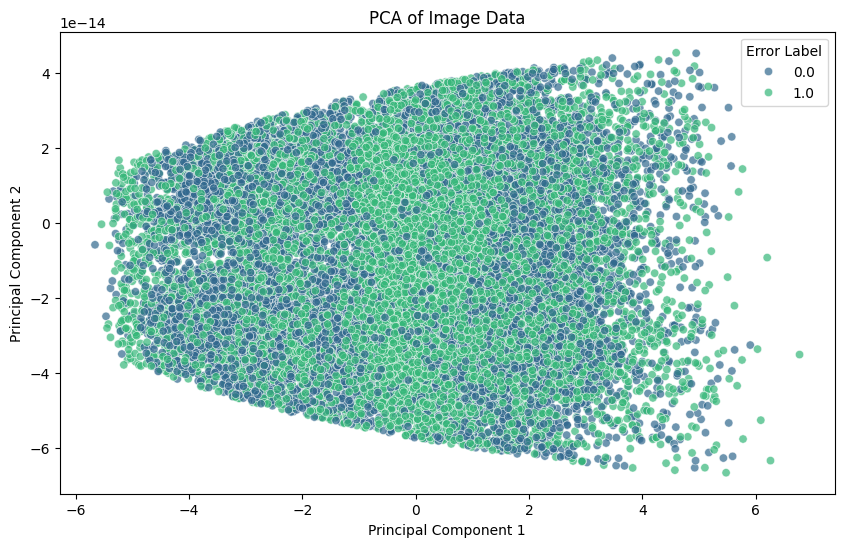

In [9]:
#e. Create DataFrame for visualization
df_pca = pd.DataFrame(image_data_pca, columns=['PC1', 'PC2'])
df_pca['Error'] = e_labels_data[:, -1].numpy()  # Use the last column of e_labels_data as error labels

#f. Plot PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Error', palette='viridis', alpha=0.7)
plt.title('PCA of Image Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Error Label')
plt.show()


### 2. Error distributions

In [10]:
#2. Compute error statistics per task, gesture and trial out.

#a. Create DataFrame for error statistics
error_df = pd.DataFrame({
    'Task': task_data.squeeze().numpy(),
    'Gesture': g_labels_data.squeeze().numpy(),
    'Trial': trial_data.squeeze().numpy(),
    'Error': e_labels_data[:, -1].numpy()  # Use the last column of e_labels_data as error labels
})

#b. Compute proportion of errors per task
error_proportion = error_df.groupby('Task')['Error'].mean().reset_index()
error_proportion['Task'] = error_proportion['Task'].map({0: 'Needle Passing', 1: 'Suturing'})
error_proportion['Number of Frames'] = error_df.groupby('Task')['Error'].count().values
print("\nProportion of Errors per Task:")
print(error_proportion)

#c. Compute proportion of errors per gesture
gesture_types = error_df['Gesture'].unique()
gesture_dict = {int(g): f'Gesture {g}' for g in gesture_types}
error_df['Gesture'] = error_df['Gesture'].map(gesture_dict)
error_proportion_gesture = error_df.groupby('Gesture')['Error'].mean().reset_index()
error_proportion_gesture['Number of Frames'] = error_df.groupby('Gesture')['Error'].count().values  
print("\nProportion of Errors per Gesture:")
print(error_proportion_gesture)

#d. Compute proportion of errors per trial
error_proportion_trial = error_df.groupby('Trial')['Error'].mean().reset_index()
error_proportion_trial['Trial'] = error_proportion_trial['Trial'].astype(str)
error_proportion_trial['Number of Frames'] = error_df.groupby('Trial')['Error'].count().values
print("\nProportion of Errors per Trial:")
print(error_proportion_trial)



Proportion of Errors per Task:
             Task     Error  Number of Frames
0  Needle Passing  0.459566             13998
1        Suturing  0.598237             19850

Proportion of Errors per Gesture:
       Gesture     Error  Number of Frames
0  Gesture 1.0  0.478022               910
1  Gesture 2.0  0.491674              8768
2  Gesture 3.0  0.550569              9136
3  Gesture 4.0  0.533902              4100
4  Gesture 5.0  0.102899              1380
5  Gesture 6.0  0.686050              6552
6  Gesture 8.0  0.558292              2599
7  Gesture 9.0  0.632754               403

Proportion of Errors per Trial:
  Trial     Error  Number of Frames
0   1.0  0.654465              8332
1   2.0  0.575628              6056
2   3.0  0.529154              7066
3   4.0  0.472940              6929
4   5.0  0.430558              5465


### 3. Kinematics Data

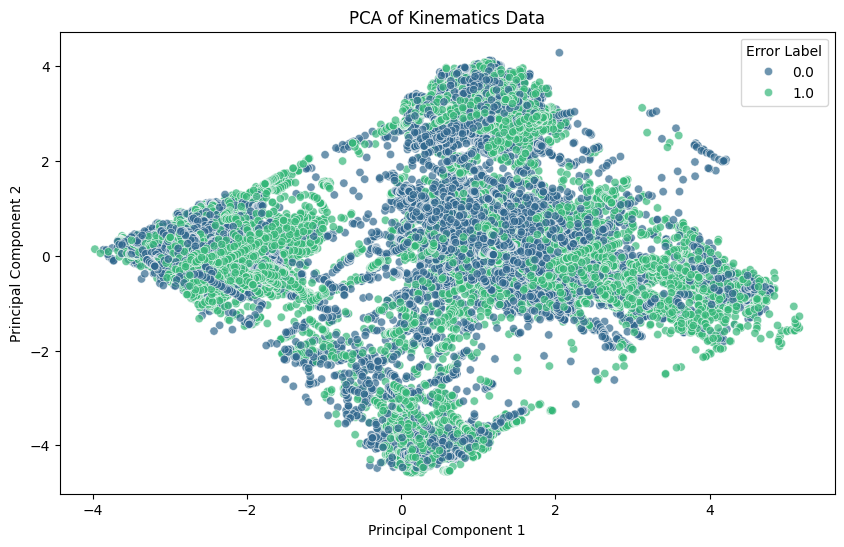

In [61]:
#3. Kinematics data EDA

#a. PCA on kinematics
pca_kinematics = PCA(n_components=2)    
#Bootstrap 10k samples to perform PCA
n_samples_kinematics = 10000
indices_kinematics = np.random.choice(kinematics_data.shape[0], n_samples_kinematics, replace=False)
pca_kinematics.fit(kinematics_data[indices_kinematics])

#Transform the kinematics data in batches
kinematics_data_pca = torch.empty((kinematics_data.shape[0], 2))
for i in range(0, kinematics_data.shape[0], 1000):
    batch = kinematics_data[i:i+1000]
    kinematics_data_pca[i:i+1000] = torch.tensor(pca_kinematics.transform(batch))

#Create DataFrame for visualization
df_kinematics_pca = pd.DataFrame(kinematics_data_pca, columns=['PC1', 'PC2'])
df_kinematics_pca['Error'] = e_labels_data[:, -1].numpy()  # Use the last column of e_labels_data as error labels
#c. Plot PCA results for kinematics data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_kinematics_pca, x='PC1', y='PC2', hue='Error', palette='viridis', alpha=0.7)
plt.title('PCA of Kinematics Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Error Label')
plt.show()

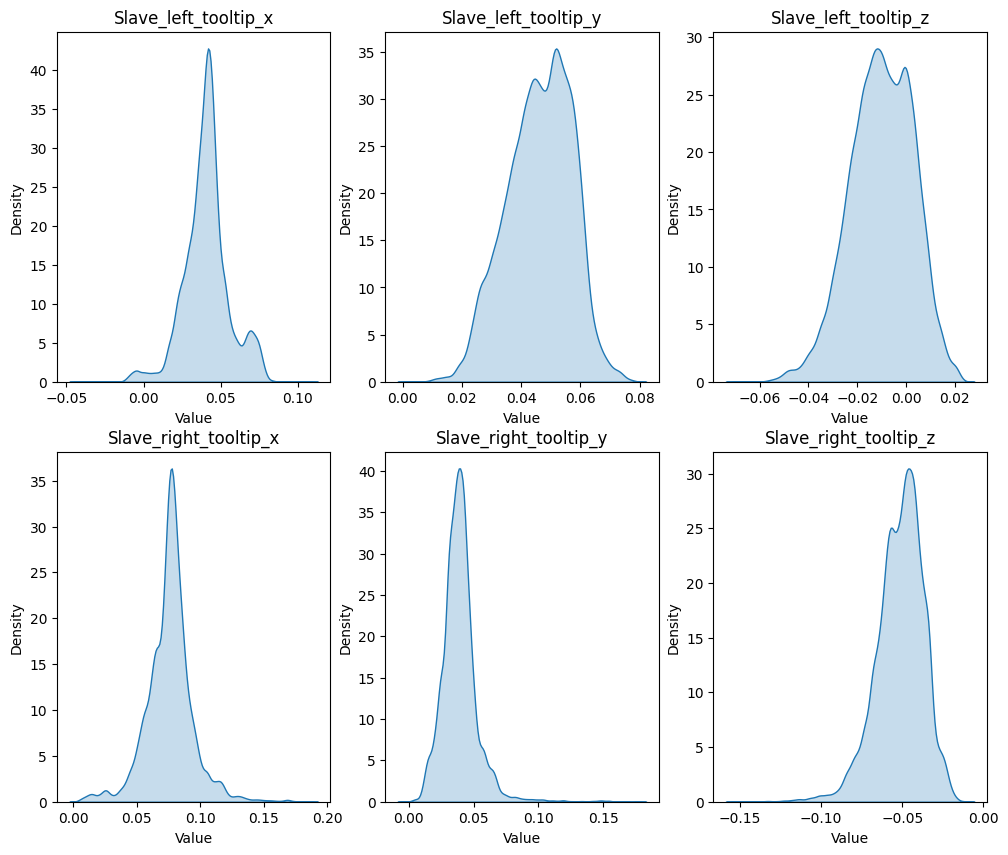

In [62]:
#2. Analyse distribution (KDE plot) of each variable
"""
kinematic variables
1-3    (3) : Master left tooltip xyz                    
4-6   (3) : Master left tooltip roll, pitch, yaw 
7-9  (3) : Master left tooltip trans_vel x', y', z'   
10-12  (3) : Master left tooltip rot_vel                
13    (1) : Master left gripper angle   
14-16 (3) : Master right tooltip xyz
17-19 (3) : Master right tooltip roll, pitch, yaw
20-22 (3) : Master right tooltip trans_vel x', y', z'  
23-25 (3) : Master right tooltip rot_vel
26    (1) : Master right gripper angle         

"""

# Create a DataFrame for kinematics data
kinematic_columns_processed = ["Slave_left_tooltip_x", "Slave_left_tooltip_y", "Slave_left_tooltip_z",
                                 "Slave_left_tooltip_roll", "Slave_left_tooltip_pitch", "Slave_left_tooltip_yaw",
                                 "Slave_left_tooltip_x'", "Slave_left_tooltip_y'", "Slave_left_tooltip_z'",
                                 "Slave_left_tooltip_rot_vel_x", "Slave_left_tooltip_rot_vel_y", "Slave_left_tooltip_rot_vel_z",
                                 "Slave_left_gripper_angle",
                                 "Slave_right_tooltip_x", "Slave_right_tooltip_y", "Slave_right_tooltip_z",
                                 "Slave_right_tooltip_roll", "Slave_right_tooltip_pitch", "Slave_right_tooltip_yaw",
                                 "Slave_right_tooltip_x'", "Slave_right_tooltip_y'", "Slave_right_tooltip_z'",
                                 "Slave_right_tooltip_rot_vel_x", "Slave_right_tooltip_rot_vel_y", "Slave_right_tooltip_rot_vel_z",
                                 "Slave_right_gripper_angle"]

kinematics_df = pd.DataFrame(kinematics_data.numpy(), columns=kinematic_columns_processed)

#a. KDE for tooltip positions (6 variables)
plt.figure(figsize=(12, 10))
j = 0
for i, col in enumerate(kinematic_columns_processed):

    if (col.endswith('x') or col.endswith('y') or col.endswith('z')) and "vel" not in col:
        
        plt.subplot(2, 3, j + 1)
        sns.kdeplot(kinematics_df[col], fill=True)
        plt.title(col)
        plt.xlabel('Value')
        plt.ylabel('Density')
        j += 1

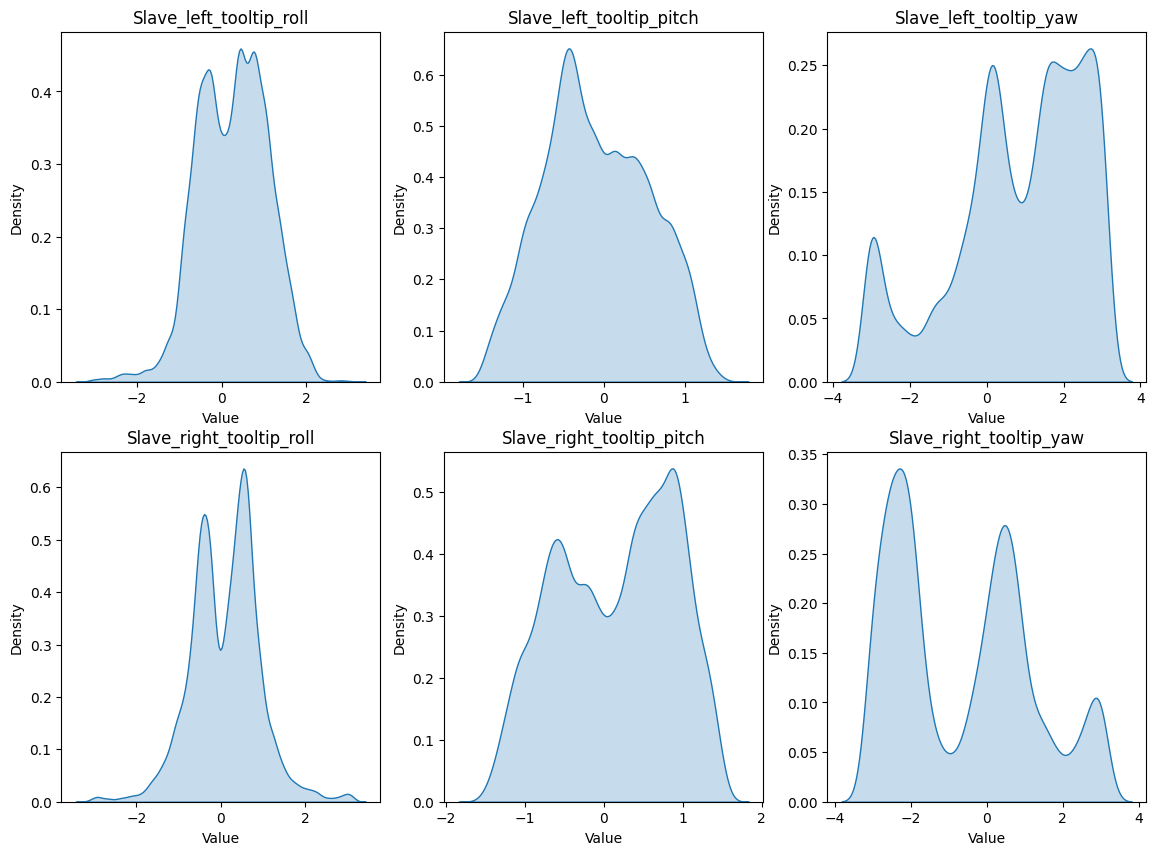

In [63]:
#b. KDE for roll, pitch, yaw (6 variables)
plt.figure(figsize=(14, 10))

j = 0
for i, col in enumerate(kinematic_columns_processed):

    if (col.endswith('roll') or col.endswith('pitch') or col.endswith('yaw')) and "vel" not in col:
        
        plt.subplot(2, 3, j + 1)
        sns.kdeplot(kinematics_df[col], fill=True)
        plt.title(col)
        plt.xlabel('Value')
        plt.ylabel('Density')
        j += 1


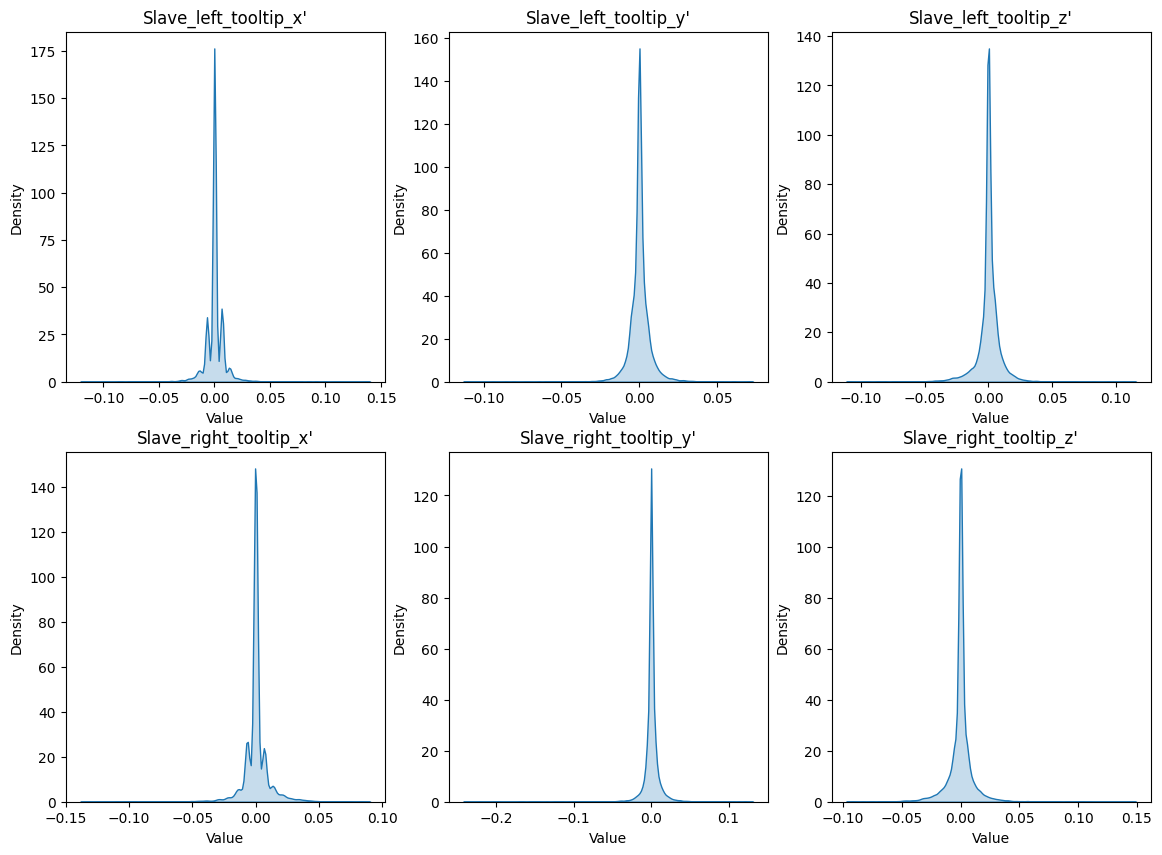

In [64]:
#c. KDE for tooltip velocities (6 variables)
plt.figure(figsize=(14, 10))

j = 0
for i, col in enumerate(kinematic_columns_processed):

    if col.endswith("'") and "rot_vel" not in col:
        
        plt.subplot(2, 3, j + 1)
        sns.kdeplot(kinematics_df[col], fill=True)
        plt.title(col)
        plt.xlabel('Value')
        plt.ylabel('Density')
        j += 1

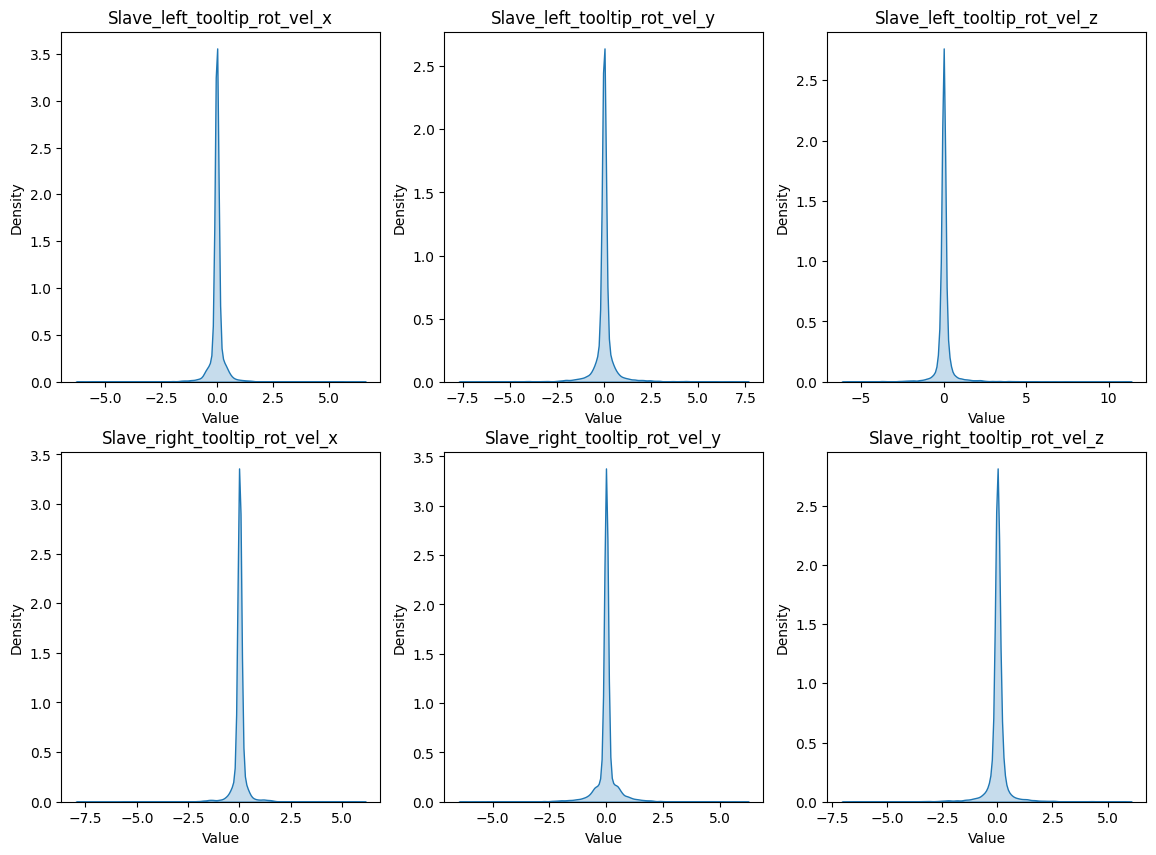

In [65]:
#d. KDE for tooltip rotational velocities (6 variables)
plt.figure(figsize=(14, 10))
j = 0
for i, col in enumerate(kinematic_columns_processed):

    if "rot_vel" in col:
        
        plt.subplot(2, 3, j + 1)
        sns.kdeplot(kinematics_df[col], fill=True)
        plt.title(col)
        plt.xlabel('Value')
        plt.ylabel('Density')
        j += 1

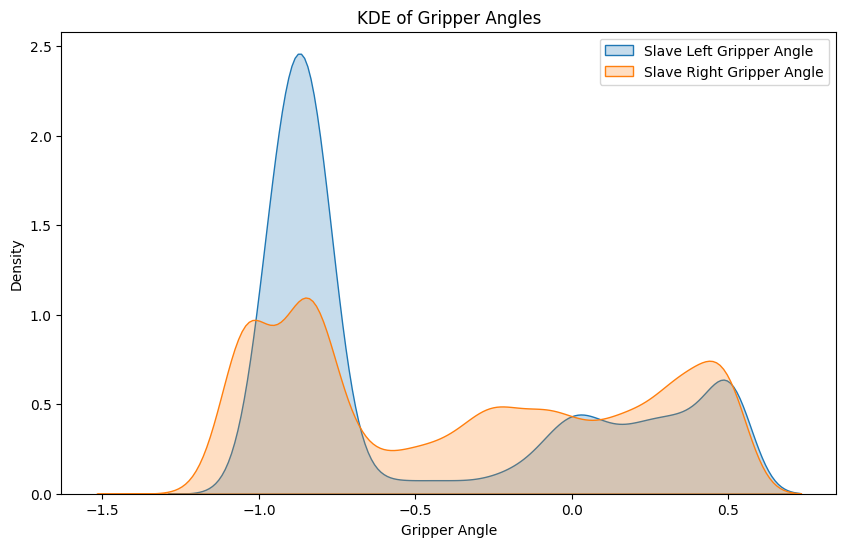

In [66]:
#e. KDE for gripper angles (2 variables)
plt.figure(figsize=(10, 6))
sns.kdeplot(kinematics_df['Slave_left_gripper_angle'], fill=True, label='Slave Left Gripper Angle')
sns.kdeplot(kinematics_df['Slave_right_gripper_angle'], fill=True, label='Slave Right Gripper Angle')
plt.title('KDE of Gripper Angles')
plt.xlabel('Gripper Angle')
plt.ylabel('Density')
plt.legend()

### 4. Mean and std of data

In [23]:
from torch.utils.data import DataLoader, TensorDataset

def compute_n_frames(root_data_path, csv_file):
    """
    Compute the number of frames based on the .pkl files in the specified directory.
    Args:
        root_dir (str): Path to the directory containing .pkl files.
    Returns:
        int: Number of frames.
    """
    n_frames = 0
    for file in csv_file['files']:
        pkl_path = os.path.join(root_data_path, file)
        if os.path.exists(pkl_path):
            with open(pkl_path, 'rb') as f:
                data = pickle.load(f)
                n_frames += data['image_feats'].shape[0]
        else:
            print(f"Warning: {pkl_path} does not exist.")

    return n_frames

def load_data(fold_data_path, csv_filename):

    """
    Load data from the specified directory and return tensors for image features, 
    kinematics features, gesture labels, error labels, task labels, trial labels, and subject labels.

    Parameters:
    root_dir (str): The directory containing the data files.

    Returns:
    tuple: A tuple containing tensors/dfs for image features, kinematics features, 
           gesture labels, error labels, task labels, trial labels, and subject labels.
    """

    csv_file = pd.read_csv(os.path.join(fold_data_path, csv_filename), header=None, names=['files'])
    n_frames = compute_n_frames(fold_data_path, csv_file)

    image_data = torch.empty((n_frames, 2048))
    kinematics_data = torch.empty((n_frames, 26))

    frame_index = 0
    for pkl_file in csv_file['files']:
        
        if pkl_file.endswith('.pkl'):
            
            pkl_path = os.path.join(fold_data_path, pkl_file)
            with open(pkl_path, 'rb') as file:
                data = pickle.load(file)

            n_frames_in_trial = data['image_feats'].shape[0]

            #i. Image features
            image_data[frame_index : frame_index + n_frames_in_trial] = data['image_feats'].reshape(n_frames_in_trial, 2048).clone().detach()/255

            #ii. Kinematics features
            kinematics_data[frame_index : frame_index + n_frames_in_trial] = data['kinematics_feats'].clone().detach()

            frame_index += n_frames_in_trial

    return image_data, kinematics_data

def compute_mean_std(filename_mean_images, 
                     filename_std_images,
                     filename_mean_kinematics,
                     filename_std_kinematics,
                     frequency,
                     full_images=False):

    outs = ['1out','2out','3out','4out','5out']
    for out in outs:
        fold_data_path = f'../data/LOSO/{frequency}Hz/' + out + '/'

        image_train, kinematics_train = load_data(fold_data_path=fold_data_path, csv_filename='train.csv')

        #Compute mean, std of image_train 
        if full_images:
            batch_size = 64
            loader = DataLoader(TensorDataset(image_train), batch_size=batch_size, shuffle=False)

            n_pixels = 0
            channel_sum = torch.zeros(3)
            channel_squared_sum = torch.zeros(3)
        

            for batch in loader:
                images = batch[0]  # Shape: (B, 3, 224, 224)
                n_pixels += images.numel() / 3  # Total number of pixels per channel

                channel_sum += images.sum(dim=[0, 2, 3])  # Sum over batch, height, width
                channel_squared_sum += (images ** 2).sum(dim=[0, 2, 3])

            mean_images = channel_sum / n_pixels
            std_images= (channel_squared_sum / n_pixels - mean_images ** 2).sqrt()

            print(f"Mean images: {mean_images}")
            print(f"Std images: {mean_images}")


        else: #Shape: (B, 2048)
            mean_images = image_train.mean(dim=0)
            std_images = image_train.std(dim=0)

            print(f"Mean images shape: {mean_images.shape}")
            print(f"Std images shape: {std_images.shape}")
        

        #Save mean and std
        mean_path = os.path.join(fold_data_path, filename_mean_images)
        std_path = os.path.join(fold_data_path, filename_std_images)
        torch.save(mean_images, mean_path)
        torch.save(std_images, std_path) 

        #Compute mean, std of kinematics_train (26 variables)
        kinematics_train = kinematics_train.numpy()
        mean_kinematics = np.mean(kinematics_train, axis=0)
        std_kinematics = np.std(kinematics_train, axis=0)
        
        #Save mean and std
        mean_kinematics_path = os.path.join(fold_data_path, filename_mean_kinematics)
        std_kinematics_path = os.path.join(fold_data_path, filename_std_kinematics)
        torch.save(torch.tensor(mean_kinematics), mean_kinematics_path)
        torch.save(torch.tensor(std_kinematics), std_kinematics_path)    


compute_mean_std(filename_mean_images='mean_features.pth',
                    filename_std_images='std_features.pth',
                    filename_mean_kinematics='mean_kinematics.pth',
                    filename_std_kinematics='std_kinematics.pth',
                    frequency=15)

Mean images shape: torch.Size([2048])
Std images shape: torch.Size([2048])
Mean images shape: torch.Size([2048])
Std images shape: torch.Size([2048])
Mean images shape: torch.Size([2048])
Std images shape: torch.Size([2048])
Mean images shape: torch.Size([2048])
Std images shape: torch.Size([2048])
Mean images shape: torch.Size([2048])
Std images shape: torch.Size([2048])


In [22]:
outs = ['1out','2out','3out','4out','5out']
for out in outs:
    fold_data_path = '../data/LOSO/5Hz/' + out + '/'

    mean = torch.load(os.path.join(fold_data_path, 'mean_features.pth'))
    std = torch.load(os.path.join(fold_data_path, 'std_features.pth'))

    print(f"Mean: {mean}")
    print(f"Std: {std}")

Mean: tensor([2.8582e-03, 1.7698e-03, 1.6756e-03,  ..., 8.5499e-04, 6.4030e-05,
        3.0390e-03])
Std: tensor([6.0942e-04, 4.2141e-04, 4.8236e-04,  ..., 2.6386e-04, 5.1619e-05,
        5.0848e-04])
Mean: tensor([0.0005, 0.0004, 0.0012,  ..., 0.0007, 0.0004, 0.0005])
Std: tensor([0.0003, 0.0002, 0.0004,  ..., 0.0003, 0.0002, 0.0001])
Mean: tensor([0.0044, 0.0040, 0.0015,  ..., 0.0004, 0.0004, 0.0011])
Std: tensor([0.0006, 0.0005, 0.0004,  ..., 0.0002, 0.0003, 0.0003])
Mean: tensor([3.1591e-03, 3.3658e-03, 9.1821e-04,  ..., 1.3564e-03, 1.3367e-05,
        2.7866e-03])
Std: tensor([5.0208e-04, 9.6955e-04, 5.5787e-04,  ..., 5.1514e-04, 2.5860e-05,
        4.4128e-04])
Mean: tensor([0.0011, 0.0024, 0.0004,  ..., 0.0013, 0.0005, 0.0022])
Std: tensor([0.0008, 0.0005, 0.0004,  ..., 0.0003, 0.0004, 0.0008])


## 5. Compute min and max length of each gesture across tasks.

In [ ]:
#Compute min and max length of each gesture per task.

gesture_folder_needle_passing = "../data/5Hz/Needle_Passing/gestures/"
gesture_folder_suturing = "../data/5Hz/Suturing/gestures/"

df_needle_passing = pd.DataFrame(columns=['gesture', 'min_length', 'max_length'], index = range(1, 10))
df_suturing = pd.DataFrame(columns=['gesture', 'min_length', 'max_length'], index = range(1, 10))

for filename in os.listdir(gesture_folder_needle_passing):
    if not filename.endswith('.npy'):
        continue
    
    #Load gesture vector
    gesture_vector = np.load(os.path.join(gesture_folder_needle_passing, filename))
    
    #Count the number of frames for each gesture
    unique, counts = np.unique(gesture_vector, return_counts=True)
    
    #Update the dataframe with min and max length for each gesture
    for gesture, count in zip(unique, counts):
        if gesture != 0:  # Skip background gesture
            if df_needle_passing.loc[gesture , 'gesture'] != gesture:
                df_needle_passing.loc[gesture , 'gesture'] = gesture
            if pd.isna(df_needle_passing.loc[gesture , 'min_length']) or count < df_needle_passing.loc[gesture , 'min_length']:
                df_needle_passing.loc[gesture , 'min_length'] = count
            if pd.isna(df_needle_passing.loc[gesture , 'max_length']) or count > df_needle_passing.loc[gesture , 'max_length']:
                df_needle_passing.loc[gesture , 'max_length'] = count


display(df_needle_passing)


for filename in os.listdir(gesture_folder_suturing):
    if not filename.endswith('.npy'):
        continue
    
    #Load gesture vector
    gesture_vector = np.load(os.path.join(gesture_folder_suturing, filename))
    
    #Count the number of frames for each gesture
    unique, counts = np.unique(gesture_vector, return_counts=True)
    
    #Update the dataframe with min and max length for each gesture
    for gesture, count in zip(unique, counts):
        if gesture != 0:  # Skip background gesture
            if df_suturing.loc[gesture , 'gesture'] != gesture:
                df_suturing.loc[gesture , 'gesture'] = gesture
            if pd.isna(df_suturing.loc[gesture , 'min_length']) or count < df_suturing.loc[gesture , 'min_length']:
                df_suturing.loc[gesture , 'min_length'] = count
            if pd.isna(df_suturing.loc[gesture , 'max_length']) or count > df_suturing.loc[gesture , 'max_length']:
                df_suturing.loc[gesture , 'max_length'] = count

display(df_suturing)



,gesture,min_length,max_length
1,1,3,70
2,2,90,474
3,3,13,124
4,4,16,80
5,5,8,120
6,6,28,191
7,NaN,NaN,NaN
8,8,13,122
9,9,32,32


,gesture,min_length,max_length
1,1,2,23
2,2,38,230
3,3,84,612
4,4,38,137
5,5,4,41
6,6,35,179
7,NaN,NaN,NaN
8,8,8,427
9,9,8,100


In [ ]:
#Compute total number of gestures per task, and compute number of gestures smaller than 10 frames

total_gestures_needle_passing = 0
total_gestures_suturing = 0

gestures_smaller_than_10_frames_needle_passing = 0
gestures_smaller_than_10_frames_suturing = 0

for filename in os.listdir(gesture_folder_needle_passing):
    if not filename.endswith('.npy'):
        continue
    
    #Load gesture vector
    gesture_vector = np.load(os.path.join(gesture_folder_needle_passing, filename))
    
    #Count the number of gestures
    unique, counts = np.unique(gesture_vector, return_counts=True)
    
    total_gestures_needle_passing += len(unique) - 1  # Exclude background gesture
    
    #Count gestures smaller than 10 frames
    for i, count in enumerate(counts):
        if count < 10:
            print(f"Gesture {unique[i]} has {count} frames, which is smaller than 10 frames.")
            gestures_smaller_than_10_frames_needle_passing += 1

print(f"Total gestures in Needle Passing: {total_gestures_needle_passing}")
print(f"Gestures shorter than 10 frames in Needle Passing: {gestures_smaller_than_10_frames_needle_passing}")

for filename in os.listdir(gesture_folder_suturing):
    if not filename.endswith('.npy'):
        continue
    
    #Load gesture vector
    gesture_vector = np.load(os.path.join(gesture_folder_suturing, filename))
    
    #Count the number of gestures
    unique, counts = np.unique(gesture_vector, return_counts=True)
    
    total_gestures_suturing += len(unique) - 1  # Exclude background gesture
    
    #Count gestures smaller than 10 frames
    for i, count in enumerate(counts):
        if count < 10:
            print(f"Gesture {unique[i]} has {count} frames, which is smaller than 10 frames.")
            gestures_smaller_than_10_frames_suturing += 1

print(f"Total gestures in Suturing: {total_gestures_suturing}")
print(f"Gestures shorter than 10 frames in Suturing: {gestures_smaller_than_10_frames_suturing}")

Gesture 1 has 3 frames, which is smaller than 10 frames.
Gesture 1 has 8 frames, which is smaller than 10 frames.
Gesture 1 has 9 frames, which is smaller than 10 frames.
Gesture 1 has 6 frames, which is smaller than 10 frames.
Gesture 5 has 8 frames, which is smaller than 10 frames.
Total gestures in Needle Passing: 156
Gestures shorte than 10 frames in Needle Passing: 5
Gesture 1 has 5 frames, which is smaller than 10 frames.
Gesture 5 has 8 frames, which is smaller than 10 frames.
Gesture 5 has 9 frames, which is smaller than 10 frames.
Gesture 1 has 8 frames, which is smaller than 10 frames.
Gesture 5 has 9 frames, which is smaller than 10 frames.
Gesture 9 has 8 frames, which is smaller than 10 frames.
Gesture 1 has 9 frames, which is smaller than 10 frames.
Gesture 8 has 8 frames, which is smaller than 10 frames.
Gesture 1 has 6 frames, which is smaller than 10 frames.
Gesture 1 has 2 frames, which is smaller than 10 frames.
Gesture 1 has 8 frames, which is smaller than 10 frames